In [32]:
#Kernel which can allow non-diagonal entries later
import math
import torch
import gpytorch
import xlwt

import torch

from gpytorch.kernels import RBFKernel
import xlrd
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from gpytorch.distributions import MultivariateNormal
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.models import ExactGP


This is a helper function to load in the input data. 

In [33]:
%pdb

Automatic pdb calling has been turned OFF


In [34]:
def generate_data(file_loc=r"C:\Users\ROG\Desktop\test1\test.xls"):
    #X data generation
    excel = xlrd.open_workbook(file_loc)

    all_sheet = excel.sheets()

    database = all_sheet[0]
    result=database.col_values(0)[3:]
    matname=database.col_values(1)[3:]
    dsq=database.col_values(2)[3:]
    dv=database.col_values(3)[3:]
    adata=database.col_values(10)[3:]
    cdata=database.col_values(11)[3:]

    ele0=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe',
         'Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb',
         'Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os',
         'Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm','Md',
         'No','Lr']
    elene=[2.20,0,0.98,1.57,2.04,2.55,3.04,3.44,3.98,0,0.93,1.31,1.61,1.90,2.19,2.58,3.16,0,0.82,1.00,1.36,1.54,1.63,1.66,
          1.55,1.83,1.88,1.91,1.90,1.65,1.81,2.01,2.18,2.55,2.96,3.00,0.82,0.95,1.22,1.33,1.6,2.16,1.9,2.2,2.28,2.2,1.93,1.69,1.78,
          1.96,2.05,2.1,2.66,2.60,0.79,0.89,1.1,1.12,1.13,1.14,1.13,1.17,1.2,1.2,1.1,1.22,1.23,1.24,1.25,1.1,1.27,1.3,1.5,2.36,1.9,
          2.2,2.20,2.28,2.54,2.0,1.62,1.87,2.02,2.0,2.2,2.2,0.795,0.9,1.1,1.3,1.5,1.38,1.36,1.28,1.13,1.28,1.3,1.3,1.3,1.3,1.3,1.3,1.3]
    elena=[72.769,-48.2,59.633,-48.2,26.989,121.776,-6.8,140.976,328.165,-116.19,52.867,-40.19,41.763,134.068,72.037,200.410,348.575,
          -96.2,48.383,2.37,18.2,7.289,50.911,65.21,-50.2,14.785,63.898,111.65,119.235,-58.2,29.061,118.935,77.65,194.959,324.537,-96.2,
          46.884,5.023,29.6,41.807,88.517,72.1,53.2,100.96,110.27,54.24,125.862,-68.2,37.043,107.298,101.059,190.161,295.153,-77.2,45.505,
          13.954,53.795,55.2,10.539,9.406,12.45,15.63,11.2,13.22,12.670,33.96,32.61,30.10,99.3,-1.93,23.04,17.18,31.2,78.76,5.8273,103.99,
          150.94,205.041,222.747,-48.2,36.414,34.4183,90.924,136.7,223.12,-68.2,46.89,9.6485,33.77,112.72,53.03,50.94,45.85,-48.33,9.93,
          27.17,-165.24,-97.31,-28.6,33.96,93.91,-223.22,-30.04]
    rcov=[31.5,28,128.7,96.3,84.3,76.1,71.1,66.2,57.3,58,166.9,141.7,121.4,111.2,107.3,105.3,102.4,106.1,203.1,176.1,170.7,160.8,153.8,
         139.5,139.5,132.3,126.3,124.4,132.4,122.4,122.3,120.4,119.4,120.4,120.3,116.4,220.9,195.1,190.7,175.7,164.6,154.5,147.7,146.7,
         142.7,139.6,145.5,144.9,142.5,139.4,139.5,138.4,139.3,140.9,244.1,215.1,207.8,204.9,203.7,201.6,199,198.8,198.6,196.6,194.5,
         192.7,192.7,189.6,190.1,187.8,175.1,187.8,170.8,162.7,151.7,144.4,141.6,136.5,136.6,132.5,145.7,146.5,148.4,140.4,150,150,260,
         221.2,215,206.6,200,196.7,190.1,187.1,180.6,169.3,166,168,165,167,173,176,161]
    eleipabs=[13.60,24.59,5.392,9.323,8.298,11.26,14.53,13.62,17.42,21.56,5.139,7.646,5.986,8.152,10.49,10.36,12.97,15.76,4.341,6.113,6.562,
          6.828,6.746,6.767,7.434,7.902,7.881,7.640,7.726,9.394,5.999,7.899,9.789,9.752,11.81,14.00,4.177,5.695,6.217,6.634,6.759,7.092,
          7.280,7.361,7.459,8.337,7.576,8.994,5.786,7.344,8.608,9.010,10.45,12.13,3.894,5.212,5.577,5.539,5.473,5.525,5.582,5.644,5.670,
          6.150,5.864,5.939,6.022,6.108,6.184,6.254,5.426,6.825,7.550,7.864,7.834,8.438,8.967,8.959,9.226,10.44,6.108,7.417,7.286,8.417,
          9.318,10.75,4.073,5.278,5.17,6.307,5.89,6.194,6.266,6.026,5.974,5.992,6.198,6.282,6.42,6.50,6.58,6.65,4.9]
    eleip=[]
    for i in eleipabs:
        eleip.append(-i)
    Xtot=[]   
    for i in range(len(matname)):
        elements=[]
        for j in range(len(matname[i])):
            if (ord(matname[i][j])>64)&(ord(matname[i][j])<91):
                ele=matname[i][j]
                if j<(len(matname[i])-1):
                    if (ord(matname[i][j+1])>96)&(ord(matname[i][j+1])<123):
                        ele=ele+matname[i][j+1]
                rep=0
                for k in elements:
                    if(j==ele):
                        rep=1
                if(rep==0):
                    elements.append(ele)
        ea,ip,en,rc=[],[],[],[]
        for j in range(len(elements)):
            for k in range(len(ele0)):
                if(elements[j]==ele0[k]):
                    ip.append(eleip[k])
                    ea.append(elena[k])
                    en.append(elene[k])
                    rc.append(rcov[k])
        ipmax=max(ip)
        eamax=max(ea)
        enmax=max(en)
        ipmin=min(ip)
        eamin=min(ea)
        enmin=min(en)
        rmax=max(rc)
        rmin=min(rc)
        datapoint=[eamax,enmax,ipmax,eamin,enmin,ipmin,adata[i],cdata[i],dsq[i],dv[i],rmax,rmin]
        Xtot.append(datapoint)

    print(len(Xtot),len(Xtot[0]))
    for i in range(len(Xtot[0])):
        max1=0
        min1=0
        for j in range(len(Xtot)):
            if Xtot[j][i]>max1:
                max1=Xtot[j][i]
            if Xtot[j][i]<min1:
                min1=Xtot[j][i]
        ruler=max1-min1
        for j in range(len(Xtot)):
            Xtot[j][i]=Xtot[j][i]-min1
            Xtot[j][i]=Xtot[j][i]/ruler
            
    labels = [x[0] == "y" for x in result]
    labels = torch.tensor(labels) * 1
    return torch.tensor(Xtot, dtype=torch.float32), labels

## Model Specifications

Let's be pretty clear about naming our models so that we can tell them apart.

My projected GP model assumes that $f(x) \sim GP(\mu(Px), k(Px, Px')$

In [35]:
#Model1 use DIY kernel above. Model0 use RBFkernel in gpytorch
class ProjectedExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood = None, rank=1):
        if likelihood is None:
            likelihood = GaussianLikelihood()
            
        super(ProjectedExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module=ConstantMean()
        self.covar_module_projection = RBFKernel(
            ard_num_dims=rank, 
            lengthscale_constraint=gpytorch.constraints.Interval(0.01, 3.),
        )
        self.register_parameter(
            "projection",torch.nn.Parameter(torch.randn(train_x.shape[-1], rank, requires_grad=True))
        )
        #self.register_constraint(
        #    "projection",gpytorch.constraints.Interval(0.01, 10.)
       # )
        self.covar_module_ard = RBFKernel(
            ard_num_dims=train_x.shape[-1],
            lengthscale_constraint=gpytorch.constraints.Interval(0.01, 3.)
        )
        self.likelihood = likelihood

    def forward(self, x):
        
        proj_x = x.matmul(self.projection)
        
        mean_x=self.mean_module(x)
        
        # this kernel is exp(-l_1^2 (x - x')P P^T(x - x') - l_2^2 (x - x')D(x - x'))
        # because we compute the product elementwise
        covar_x=self.covar_module_projection(proj_x) * self.covar_module_ard(x)
        
        return MultivariateNormal(mean_x, covar_x)

class ExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood = None, ard_num_dims=None):
        if likelihood is None:
            likelihood = GaussianLikelihood()
            
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module=ConstantMean()
        self.covar_module = RBFKernel(
            ard_num_dims=ard_num_dims, lengthscale_constraint=gpytorch.constraints.Interval(0.01, 3.)
        )
        self.likelihood = likelihood
        
    def forward(self, x):
        mean_x=self.mean_module(x)
        covar_x=self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

First, I load in the input data.

In [5]:
Dptt, true_y = generate_data()

1279 12


## Lengthscale Recovery

I'm going to take the true responses and add a little bit of Gaussian noise just to make it somewhat more of a continuous function. In the future, we can use gpytorch.likelihoods.DirichletRegressionLikelihood.

In [6]:
y_resp = true_y.float() + 0.01 * torch.randn_like(true_y.float())

I'm going to use 1000 training points and 249 testing points.

In [7]:
shuffled_inds = torch.randperm(Dptt.shape[0])
trainset = shuffled_inds[:1000]
testset = shuffled_inds[1000:]

In [8]:
model = ExactGPModel(Dptt[trainset], y_resp[trainset], ard_num_dims=Dptt.shape[-1])

In [143]:
[print(n) for n, p in model.named_parameters()]

likelihood.noise_covar.raw_noise
mean_module.constant
covar_module.raw_lengthscale


[None, None, None]

In [ ]:
model.train()
model.likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
mll = ExactMarginalLogLikelihood(model.likelihood, model)

for i in range(600):
    loss = -mll(model(Dptt[trainset]), y_resp[trainset])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 100 == 0:
        print("Step: ", i, "Lengthscales: ", model.covar_module.lengthscale.data, "Loss: ", loss.item())

ModuleAttributeError: 'ProjectedExactGPModel' object has no attribute 'covar_module'

> e:\ana\lib\site-packages\torch\nn\modules\module.py(779)__getattr__()
    777                 return modules[name]
    778         raise ModuleAttributeError("'{}' object has no attribute '{}'".format(
--> 779             type(self).__name__, name))
    780 
    781     def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:



In [145]:
model.eval()
model.likelihood.eval()

with torch.no_grad():
    pred = model.likelihood(model(Dptt[testset]))

In [146]:
import matplotlib.pyplot as plt

In [147]:
testset_accuracy = ((pred.mean > 0.5) == (y_resp[testset] > 0.5)).float().mean()

Text(0, 0.5, 'Predicted')

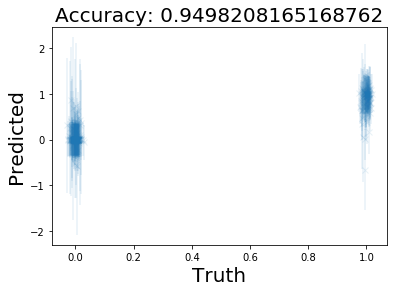

In [148]:
plt.title("Accuracy: " + str(testset_accuracy.item()), fontsize = 20)
plt.errorbar(y_resp[testset], pred.mean, yerr = 2. * pred.variance ** 0.5, ls='none', alpha = 0.1, marker = "x")
plt.xlabel("Truth", fontsize = 20)
plt.ylabel("Predicted", fontsize = 20)

Accuracy is 91.4% which seems reasonable.

## Projected GP Model

Next, I'm going to fit the projected GP model which should give use a relationship between the parameters as well.

In [36]:
model = ProjectedExactGPModel(Dptt[trainset], y_resp[trainset], rank=1, likelihood=DirichletClassificationLikelihood)
# model.likelihood.noise = 0.01
# model.covar_module.lengthscale = 3. * torch.ones_like(model.covar_module.lengthscale)

[print(n) for n, p in model.named_parameters()]

model.train()
model.likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
mll = ExactMarginalLogLikelihood(model.likelihood, model)

for i in range(500):
    loss = -mll(model(Dptt[trainset]), y_resp[trainset])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 100 == 0:
        print("Step: ", i, "Lengthscales: ", model.covar_module_ard.lengthscale.data, "Loss: ", loss.item())



RuntimeError: ExactGP can only handle Gaussian likelihoods

Text(0, 0.5, 'Predicted')

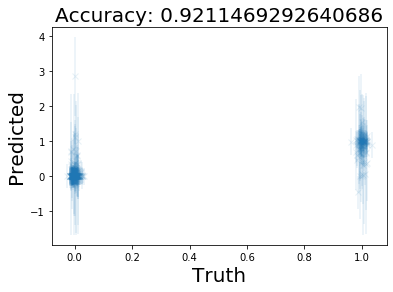

In [19]:
model.eval()
model.likelihood.eval()

with torch.no_grad():
    pred = model.likelihood(model(Dptt[testset]))

import matplotlib.pyplot as plt

testset_accuracy = ((pred.mean > 0.5) == (y_resp[testset] > 0.5)).float().mean()

plt.title("Accuracy: " + str(testset_accuracy.item()), fontsize = 20)
plt.errorbar(y_resp[testset], pred.mean, yerr = 2. * pred.variance ** 0.5, ls='none', alpha = 0.1, marker = "x")
plt.xlabel("Truth", fontsize = 20)
plt.ylabel("Predicted", fontsize = 20)

Accuracy is similar at about 91.8%.

Finally, I'm going to plot the estimated covariance matrix and the estimated correlation matrix between the features.

In [20]:
estimated_covar = model.projection / model.covar_module_projection.lengthscale @ model.projection.t() + \
    torch.diag(model.covar_module_ard.lengthscale.reciprocal())

In [21]:
estimated_covar.symeig()

torch.return_types.symeig(
eigenvalues=tensor([-1.8737e-05, -6.6574e-06, -1.5992e-06, -1.3336e-07,  1.2741e-07,
         2.3788e-07,  9.1725e-07,  1.9072e-06,  2.1365e-05,  3.5222e-05,
         6.4427e+00,  6.0741e+02], grad_fn=<SymeigBackward>),
eigenvectors=tensor([], grad_fn=<SymeigBackward>))

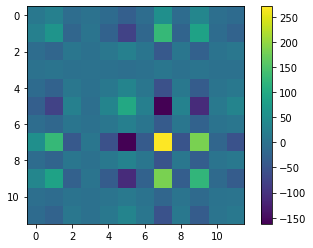

In [22]:
f = plt.imshow(estimated_covar.data)
plt.colorbar(f)

In [23]:
covar_inv_diags = estimated_covar.diag() ** 0.5
estimated_corr = estimated_covar / torch.outer(covar_inv_diags, covar_inv_diags)

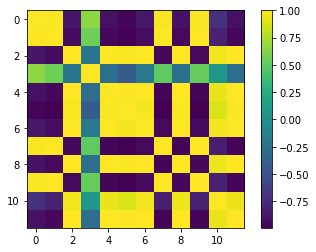

In [24]:
f = plt.imshow(estimated_corr.data)
plt.colorbar(f)

This is strongly suggestive of two distinct clusters (features 0, 1, 7, 8, 9) and (features 2, 4, 5, 6, 11, 12) with feature 3 being slightly different from the others.

In [28]:
print(estimated_corr.data.numpy())
ttt=1-torch.abs(estimated_corr.data)
ttt=ttt.numpy()*50.0
print(ttt)
for i in range(len(ttt[0])):
    ttt[i][i]=0.0
    for j in range(i+1, len(ttt[0])):
        ttt[j][i]=ttt[i][j]
from scipy.spatial.distance import squareform

condensed_dist = squareform(ttt)
cc=[]
for i in range(len(ttt[0])):
    for j in range(i+1,len(ttt[0])):
        cc.append((ttt[i][j]))

[[ 1.          0.9914698  -0.87486047  0.661222   -0.90281963 -0.95520294
  -0.8633663   0.983749   -0.8933953   0.9874098  -0.7066579  -0.90074706]
 [ 0.9914698   1.0000001  -0.9305296   0.5578043  -0.95116574 -0.98562825
  -0.9217667   0.9987592  -0.9443311   0.99960417 -0.79285043 -0.9496746 ]
 [-0.87486047 -0.9305296   1.         -0.21510366  0.99813193  0.9790208
   0.9997298  -0.9476124   0.9992122  -0.9404656   0.9609492   0.99841344]
 [ 0.661222    0.5578043  -0.21510361  1.         -0.2743679  -0.4095815
  -0.19234775  0.5157803  -0.25369367  0.53422993  0.06354332 -0.2697533 ]
 [-0.9028195  -0.95116574  0.99813193 -0.2743679   1.0000001   0.9896408
   0.99644214 -0.96535766  0.9997703  -0.95947474  0.9422473   0.99998856]
 [-0.955203   -0.9856283   0.9790208  -0.40958154  0.9896409   1.
   0.9740205  -0.992818    0.98633635 -0.9899913   0.88440377  0.9889411 ]
 [-0.86336637 -0.9217667   0.9997299  -0.19234778  0.99644226  0.9740205
   0.99999994 -0.9399324   0.9980197  -0.932

In [31]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

def hierarchy_cluster(data, method='average', threshold=4.0):
    '''层次聚类
    
    Arguments:
        data [[0, float, ...], [float, 0, ...]] -- 文档 i 和文档 j 的距离
    
    Keyword Arguments:
        method {str} -- [linkage的方式： single、complete、average、centroid、median、ward] (default: {'average'})
        threshold {float} -- 聚类簇之间的距离
    Return:
        cluster_number int -- 聚类个数
        cluster [[idx1, idx2,..], [idx3]] -- 每一类下的索引
    '''
    data = np.array(data)
 
    Z = linkage(data, method=method)
    cluster_assignments = fcluster(Z, threshold, criterion='distance')
    print(type(cluster_assignments))
    num_clusters = cluster_assignments.max()
    indices = get_cluster_indices(cluster_assignments)
 
    return num_clusters, indices
 
 
 
def get_cluster_indices(cluster_assignments):
    '''映射每一类至原数据索引
    
    Arguments:
        cluster_assignments 层次聚类后的结果
    
    Returns:
        [[idx1, idx2,..], [idx3]] -- 每一类下的索引
    '''
    n = cluster_assignments.max()
    indices = []
    for cluster_number in range(1, n + 1):
        indices.append(np.where(cluster_assignments == cluster_number)[0])
    
    return indices

num_clusters, indices = hierarchy_cluster(condensed_dist)
 
 
print("%d clusters" % num_clusters)
for k, ind in enumerate(indices):
    print ("cluster", k + 1, "is", ind)



<class 'numpy.ndarray'>
3 clusters
cluster 1 is [0 1 5 7 9]
cluster 2 is [ 2  4  6  8 10 11]
cluster 3 is [3]
